In [1]:
!pip install efficientnet_pytorch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import os
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import datetime
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from mlxtend.evaluate import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from mlxtend.plotting import plot_confusion_matrix
from collections import OrderedDict 

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

#debug mode
debug=True
train_the_model=True
test_the_network=True
display_on_console=False
confusion_matrix_on=True
find_std_and_mean=False

n_epochs = 40
EPOCHS = 40
DEVICE = torch.device("cuda")


# define dataloader parameters
#get the batch size so that the test and training sets are correctly sliced
batch_size = 40
num_workers=8
name_of_csv="Results_of_Stage_I_Optimized_ML_Model_EfficientNetb0"
path_to_save='Stage_I_Optimzied_Model_EfficientNetb0.pth'
check_with_non_skew=False

if check_with_non_skew==True:
    batch_size = 10

In [2]:
# define training and test data directories
data_dir=r'C:\Users\makerspace.im\Desktop\Makerspace Files Jay\GUI Builds\Phase I\Pytorch'

train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['Lot Code', 'Other', 'Package', 'Product Defect', 'Receipt']


In [3]:
# percentage of training set to use as validation
valid_size = 0.2

# VGG-16 Takes 224x224 images as input, so we resize all of them
train_transforms = transforms.Compose([transforms.RandomRotation(40),
                                           transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


percentage_train_data= round((len(train_data)*100/len(train_data+test_data)))
percentage_test_data=round((len(test_data)*100/len(train_data+test_data)))

# print out some data stats
print('Num training images: {} among {} batches.|| {}% out of Total Images'.format(len(train_data),len(train_data)/batch_size,percentage_train_data) )
print('Num test images: {} among {} batches. || {}% out of Total Images'.format(len(test_data),len(test_data)/batch_size,percentage_test_data) )

Num training images: 19757 among 493.925 batches.|| 85% out of Total Images
Num test images: 3462 among 86.55 batches. || 15% out of Total Images


In [4]:
#################################
#Prepare Dataloaders for Batches#
#################################

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# prepare data loaders

test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, 
                                          num_workers=num_workers, shuffle=True)


In [5]:
def get_data():
    # Load datase
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                     sampler=train_sampler,num_workers=num_workers, shuffle=False)
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                    sampler=valid_sampler, num_workers=num_workers, shuffle=False)
    
    return train_loader, valid_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

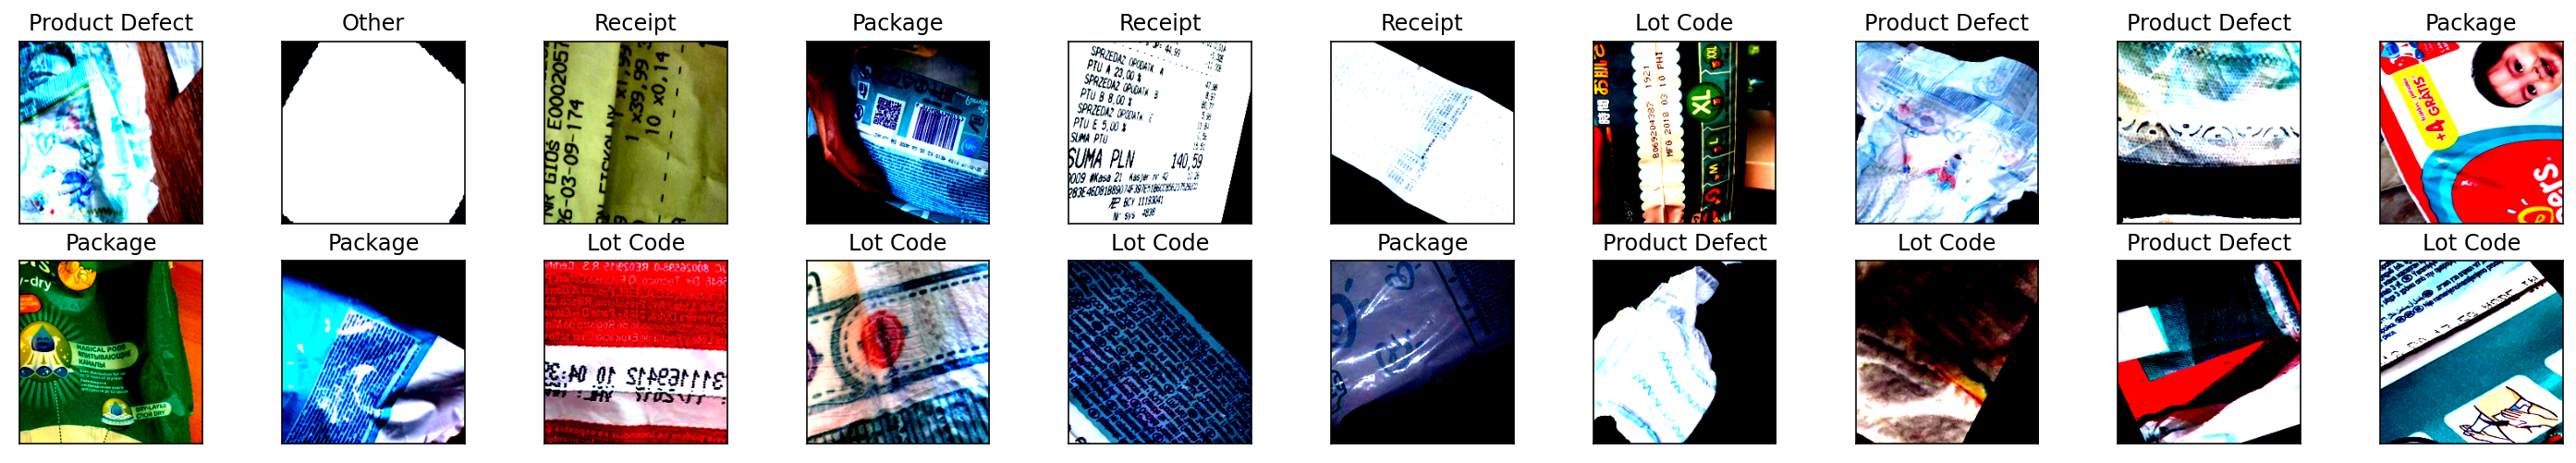

In [6]:
# Visualize some sample data
if check_with_non_skew==False:
    # obtain one batch of training images
    dataiter = iter(get_data()[0])
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display
    images.shape

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(classes[labels[idx]])

In [7]:
base_model = "EfficientNet"
from efficientnet_pytorch import EfficientNet
           
if base_model == "EfficientNet":
    
        
    base_model_efficientnet = "b0"
        
    if base_model_efficientnet == "b0":
        model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=5)
        
    in_features = model._fc.in_features

    n_layers = 2
    layers = []

    if n_layers > 0:
        out_features = 757
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        #p1 = study.best_trial.params['dropout_l1_e']
        p1 = 0.5
        layers.append(nn.Dropout(p1))
        in_features = out_features
        if n_layers > 1:
            out_features = 725
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())
            #p2 = study.best_trial.params['dropout_l2_e']
            p2 = 0.5
            layers.append(nn.Dropout(p2))
            in_features = out_features
            if n_layers > 2:
                out_features = study.best_trial.params['n_units_l2_e']
                layers.append(nn.Linear(in_features, out_features))
                layers.append(nn.ReLU())
                #p3 = study.best_trial.params['dropout_l3_e']
                p3 = 0.6
                layers.append(nn.Dropout(p3))
                in_features = out_features

    layers.append(nn.Linear(in_features, 5))

    model._fc = nn.Sequential(*layers)

print(model)

Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dS

In [8]:
DEVICE = torch.device("cuda:0")
# Generate the model

model = torch.nn.DataParallel(model, device_ids=list(range(2)))
model.to(DEVICE)


# Generate the optimizers.
optimizer_name = "SGD"
lr = 0.001
optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
    
# Get the dataset
train_loader, valid_loader = get_data()
valid_loss_min = np.Inf # track change in validation loss
training_loss_array=[]
valid_loss_array=[]

# Training of the model
model.train()
for epoch in range(EPOCHS):
    torch.cuda.empty_cache()

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    for data, target in train_loader:
    
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
            
    print('Training done.. Validating....')

    # Validation of the model.
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in valid_loader:
                
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            # Get the index of the max log-probability.
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    N_Valid_Examples = int(0.2*(len(train_loader.dataset)))
    accuracy = correct / (N_Valid_Examples*1.00)
        
    print('Accuracy for the validation dataset is : ', accuracy)
        
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/(0.2*len(valid_loader.dataset))

    # print training/validation statistics 
    print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch,EPOCHS, train_loss, valid_loss))
    
    #append data into arrays for plotting later.
    valid_loss_array.append(valid_loss)
    training_loss_array.append(train_loss)

    # save model if validation loss has decreased
    if epoch > 35:
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), path_to_save)
            valid_loss_min = valid_loss

C:\Users\makerspace.im\Anaconda3\envs\pyTorch\lib\site-packages\torch\nn\parallel\data_parallel.py:26: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
C:\Users\makerspace.im\Anaconda3\envs\pyTorch\lib\site-packages\torch\cuda\nccl.py:24: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Training done.. Validating....
Accuracy for the validation dataset is :  0.39711465451784356
Epoch: 0/40 	Training Loss: 0.031434 	Validation Loss: 0.038395
Training done.. Validating....
Accuracy for the validation dataset is :  0.39711465451784356
Epoch: 1/40 	Training Loss: 0.029027 	Validation Loss: 0.033517
Training done.. Validating....
Accuracy for the validation dataset is :  0.40673247279169833
Epoch: 2/40 	Training Loss: 0.025336 	Validation Loss: 0.029681
Training done.. Validating....
Accuracy for the validation dataset is :  0.5950392305745381
Epoch: 3/40 	Training Loss: 0.022898 	Validation Loss: 0.026913
Training done.. Validating....
Accuracy for the validation dataset is :  0.6322450012655024
Epoch: 4/40 	Training Loss: 0.020231 	Validation Loss: 0.023397
Training done.. Validating....
Accuracy for the validation dataset is :  0.6545178435839029
Epoch: 5/40 	Training Loss: 0.017868 	Validation Loss: 0.021433
Training done.. Validating....
Accuracy for the validation da

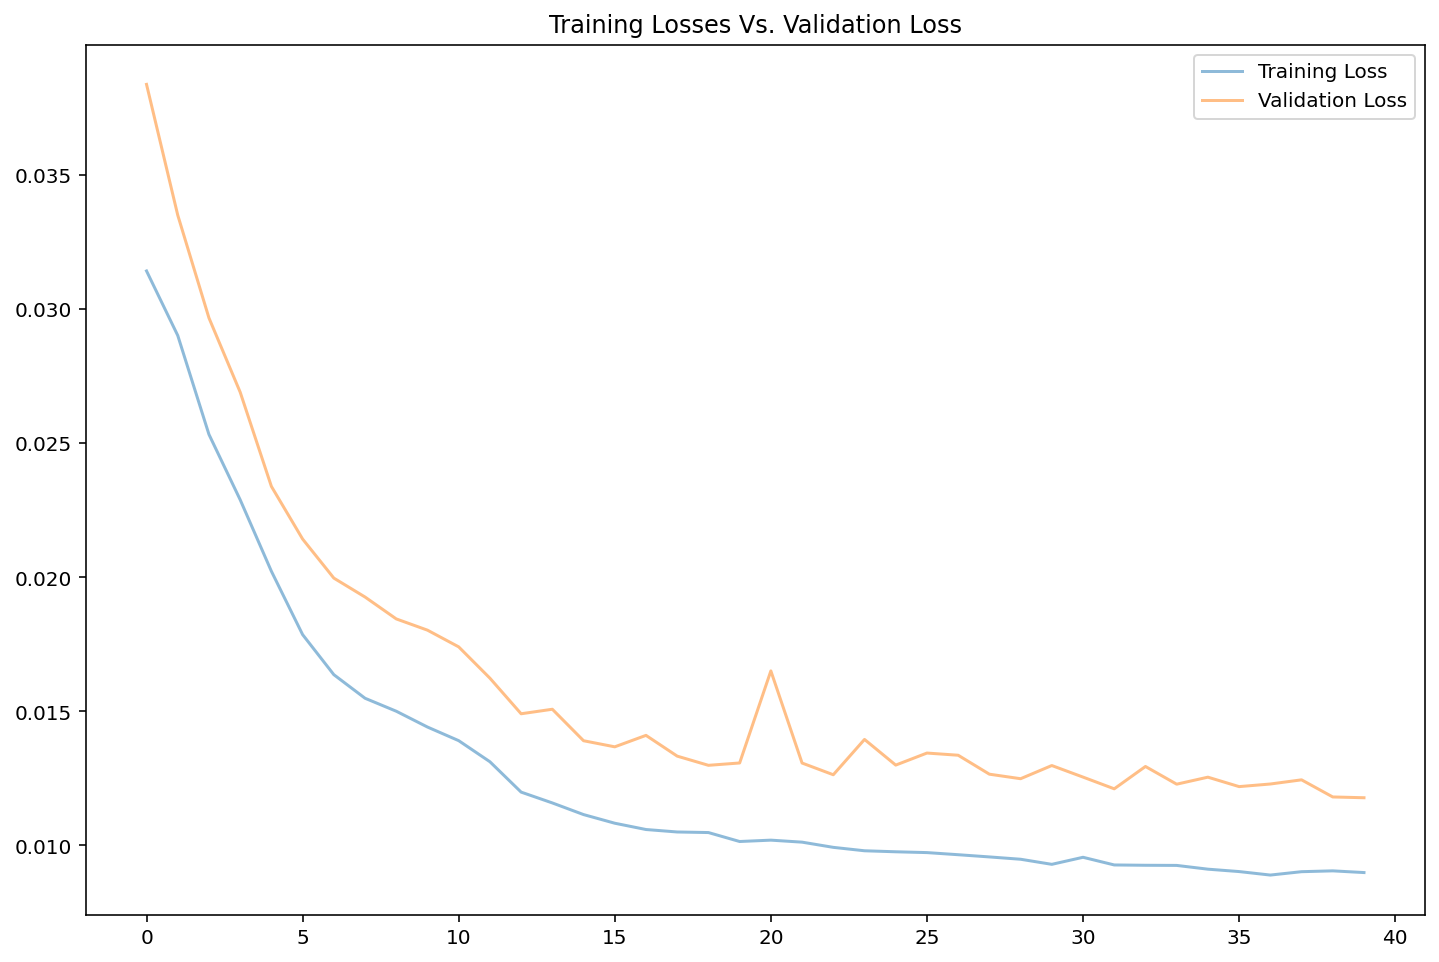

In [9]:
if train_the_model==True:
    #Plot the Validation loss Vs Training loss.. 

    fig, ax = plt.subplots(figsize=(12,8))

    plt.plot(training_loss_array, label='Training Loss', alpha=0.5)
    plt.plot(valid_loss_array, label='Validation Loss', alpha=0.5)
    plt.title("Training Losses Vs. Validation Loss")
    plt.legend()

In [10]:
model.load_state_dict(torch.load(path_to_save), strict=False)

print(model.state_dict().keys())

odict_keys(['module._conv_stem.weight', 'module._bn0.weight', 'module._bn0.bias', 'module._bn0.running_mean', 'module._bn0.running_var', 'module._bn0.num_batches_tracked', 'module._blocks.0._depthwise_conv.weight', 'module._blocks.0._bn1.weight', 'module._blocks.0._bn1.bias', 'module._blocks.0._bn1.running_mean', 'module._blocks.0._bn1.running_var', 'module._blocks.0._bn1.num_batches_tracked', 'module._blocks.0._se_reduce.weight', 'module._blocks.0._se_reduce.bias', 'module._blocks.0._se_expand.weight', 'module._blocks.0._se_expand.bias', 'module._blocks.0._project_conv.weight', 'module._blocks.0._bn2.weight', 'module._blocks.0._bn2.bias', 'module._blocks.0._bn2.running_mean', 'module._blocks.0._bn2.running_var', 'module._blocks.0._bn2.num_batches_tracked', 'module._blocks.1._expand_conv.weight', 'module._blocks.1._bn0.weight', 'module._blocks.1._bn0.bias', 'module._blocks.1._bn0.running_mean', 'module._blocks.1._bn0.running_var', 'module._blocks.1._bn0.num_batches_tracked', 'module._b

In [11]:
torch.cuda.empty_cache()

In [12]:

##########################
#Test the trained Network#
##########################
total_preds=np.array([])
total_labels=np.array([])
train_on_gpu = True
if test_the_network==True:
    # track test loss 
    # over 5  classes
    test_loss = 0.0
    class_correct = list(0. for i in range(5))
    class_total = list(0. for i in range(5))

    batch_number=0

    model.eval() # evaluation mode

    if debug==True:
        print('----------- Debugging mode On -----------')
    #if check_with_non_skew==True:
        #print("******These are accuracies for non-skewed classes******")
    # iterate over test data
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        #debug step --- print('The output:{}'.format(output.shape))
        # calculate the batch loss
        loss = criterion(output, target)
        # update  test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1) 
        batch_number = batch_number + 1
        ###########################################################################################
        #for debugging
        if debug==True:        
            print('Validating--> Batch number: {} with {} input images...'.format(batch_number,pred.shape[0]))


        ##########################################################################################

        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(pred.shape[0]):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate avg test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(5):
        print('Test Accuracy of %5s class is: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))


    print('\n Test Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))


----------- Debugging mode On -----------
Validating--> Batch number: 1 with 20 input images...
Validating--> Batch number: 2 with 20 input images...
Validating--> Batch number: 3 with 20 input images...
Validating--> Batch number: 4 with 20 input images...
Validating--> Batch number: 5 with 20 input images...
Validating--> Batch number: 6 with 20 input images...
Validating--> Batch number: 7 with 20 input images...
Validating--> Batch number: 8 with 20 input images...
Validating--> Batch number: 9 with 20 input images...
Validating--> Batch number: 10 with 20 input images...
Validating--> Batch number: 11 with 20 input images...
Validating--> Batch number: 12 with 20 input images...
Validating--> Batch number: 13 with 20 input images...
Validating--> Batch number: 14 with 20 input images...
Validating--> Batch number: 15 with 20 input images...
Validating--> Batch number: 16 with 20 input images...
Validating--> Batch number: 17 with 20 input images...
Validating--> Batch number: 18 w

Validating--> Batch number: 149 with 20 input images...
Validating--> Batch number: 150 with 20 input images...
Validating--> Batch number: 151 with 20 input images...
Validating--> Batch number: 152 with 20 input images...
Validating--> Batch number: 153 with 20 input images...
Validating--> Batch number: 154 with 20 input images...
Validating--> Batch number: 155 with 20 input images...
Validating--> Batch number: 156 with 20 input images...
Validating--> Batch number: 157 with 20 input images...
Validating--> Batch number: 158 with 20 input images...
Validating--> Batch number: 159 with 20 input images...
Validating--> Batch number: 160 with 20 input images...
Validating--> Batch number: 161 with 20 input images...
Validating--> Batch number: 162 with 20 input images...
Validating--> Batch number: 163 with 20 input images...
Validating--> Batch number: 164 with 20 input images...
Validating--> Batch number: 165 with 20 input images...
Validating--> Batch number: 166 with 20 input im

In [13]:
#######################
#Visualzing the sample#
#######################

############################################################
#CSV File - Predicted catergory/Actual Catergory/Image Path#
############################################################

#A dataframe with specific headings...
df = pd.DataFrame(columns=['Predicted Class','Actual Class','Correctly Classified','Path'])
batch_size = 20
no_of_batches=int(len(test_data)/batch_size)
no_rows=4
total_preds=np.array([])
total_actual_labels=np.array([])

#supress numpy warning
np.warnings.filterwarnings('ignore')

for i in range(no_of_batches):
    #sub dataframe
    sub_df = pd.DataFrame(columns=['Predicted Class','Actual Class','Correctly Classified','Path'])
    
    # obtain one batch of test images.
    # The Training dataloader will be loaded by my customs loader 
    #for image paths.
    dataiter = iter(test_loader)
    images, labels = dataiter.next()
    images.numpy()

    # move model inputs to cuda, if GPU available
    if train_on_gpu:
        images = images.cuda()

    # get sample outputs
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())


    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(80, 80))
    for idx in np.arange(len(preds)):
        if display_on_console==True:
            
            #plot and display 
            ax = fig.add_subplot(no_rows, batch_size//no_rows, idx+1, xticks=[], yticks=[])
            plt.imshow(np.transpose(images.cpu()[idx], (1, 2, 0)))
            #ax.set_title('{}'.format(paths[idx]), fontdict={'fontsize':35})
            ax.set_title("P-{} (C-{})".format(classes[preds[idx]], classes[labels[idx]]),fontdict={'fontsize':35},
                         color=("green" if preds[idx]==labels[idx].item() else "red"))
        
        #write to the CSV file
        sub_df.loc[idx,'Predicted Class'] = classes[preds[idx]]
        sub_df.loc[idx,'Actual Class']=classes[labels[idx]]
        #sub_df.loc[idx,'Path']= paths[idx]
        if preds[idx]==labels[idx].item():
            sub_df.loc[idx,'Correctly Classified']= 'Correct'
        else:
            sub_df.loc[idx,'Correctly Classified']= 'Incorrect'
    if debug==True:
        print('Test {}'.format(idx))
    #append sub_df to the main df
    df=df.append(sub_df, ignore_index=True)
    
    #make multiclass confusion matrix
    if confusion_matrix_on==True:
        total_preds=np.append(total_preds,preds)
        total_actual_labels=np.append(total_actual_labels,labels)

#saves the processed data to data.csv file
df.to_csv(name_of_csv, sep='\t',index=False,  encoding='latin-1')    
print('***Done & CSV File Generated***')


Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19


<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

In [14]:
total_actual_labels

array([3., 1., 2., ..., 3., 2., 0.])

In [15]:
len(total_actual_labels)

3460

In [16]:
total_preds

array([3., 1., 2., ..., 3., 3., 0.])

In [17]:
preds_tensor

tensor([2, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 1, 0, 2, 2, 3, 3, 0],
       device='cuda:0')

0--> Lot Code
1--> Other
2--> Package
3--> Product Defect
4--> Receipt


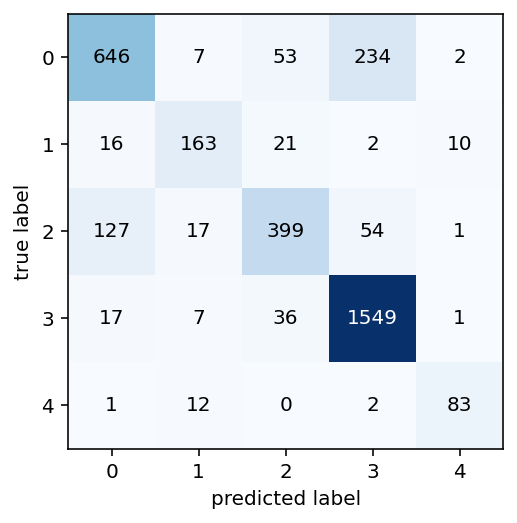

In [18]:
confusion_matrix_on=True

#make multiclass confusion matrix
if confusion_matrix_on==True:
    cm = confusion_matrix(y_target=total_actual_labels, 
                      y_predicted=total_preds, 
                      binary=False)
    for i,name in enumerate(classes):
        print('{}--> {}'.format(i,name))
    fig, ax = plot_confusion_matrix(conf_mat=cm)
    plt.show()